# Week 6 - Model Fitting - Worked Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit

## Question 1 - The Van't Hoff Equation

The Van't Hoff equation relates the equilibrium constant of a given reaction to the temperature at which that reaction occurs. The linear form can be derived from the two standard expressions for the change in Gibbs free energy:

$$\Delta G = \Delta H - T\Delta S = -RT\ln K$$

$$\ln K = -\frac{\Delta H}{RT} + \frac{\Delta S}{R}$$

Given a set of temperatures and equilibrium constants measured from experiment, we should be able to fit the linear form of the Van't Hoff equation and thus calculate $\Delta H$ and $\Delta S$ from the slope and intercept respectively.

$$2\mathrm{NO}_{2} \rightarrow \mathrm{N}_{2}\mathrm{O}_{4}$$

We are provided with T and K data for the reaction above.

|T / celsius|K|
|-----------|----|
|9          |34.3 |
|20         |12   |
|25         |8.79 |
|33         |4.4  |
|40         |2.8  |
|52         |1.4  |
|60         |0.751|
|70         |0.4  |

The exercise asks us to read data from `exercise_1.dat`. The file contains temperature and equilibrium constant data in two columns. We can read this using `np.loadtxt()`:
```python
data = np.loadtxt('data/exercise_1.dat', skiprows=1)
temperature = data[:, 0]
eq_con = data[:, 1]
```

For this worked example, we will enter the data directly:

In [2]:
temperature = np.array([9, 20, 25, 33, 40, 52, 60, 70])
eq_con = np.array([34.3, 12, 8.79, 4.4, 2.8, 1.4, 0.751, 0.4])

The linear form of the Van't Hoff equation features $\ln K$ and $1 / T$, so we need to take the reciprocol of each temperature and the natural logarithm of each K. The temperature is also in celsius, so we need to convert to kelvin. These operations are made trivial by `numpy`, which allows us to utilise vector arithmetic and operate on each element of an array _e.g_ add 273.15 to each temperature in the `temperature` array.

In [3]:
temperature_kelvin = temperature + 273.15
inverse_temperature = 1 / temperature_kelvin
ln_eq = np.log(eq_con)

As we would expect, plotting $1 / T$ against $\ln K$ gives a linear relationship.

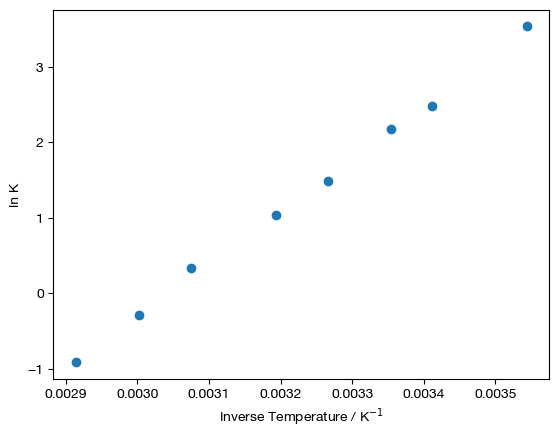

In [4]:
plt.plot(inverse_temperature, ln_eq, 'o')
plt.xlabel('Inverse Temperature / K$^{-1}$')
plt.ylabel('ln K')
plt.show()

Now we need to "pythonise" the linear form of the Van't Hoff equation. This is effectively just the equation of a straight line, so we can think of this function as a simple linear model calculating $y$ ($\ln K$) from $m$ ($-\Delta H / R$), $x$ ($1 / T$) and $c$ ($\Delta S / R$).

In [5]:
def linear_model(x, m, c):
    """
    Model the equation of a straight line, i.e. calculate y = mx + c.
    
    Args:
        x (np.ndarray): x-values
        m (float): slope
        c (float): intercept
        
    Returns:
        np.ndarray: y-values
    """
    
    y = m * x + c
    
    return y

We can test our function with a decent guess as to what $m$ and $c$ should be, these are given to us as $m = 7400$ and $c = -22.5$. We can calculate our prediction of $\ln K$ at each value of $1 / T$ by calling our `linear_model` function.

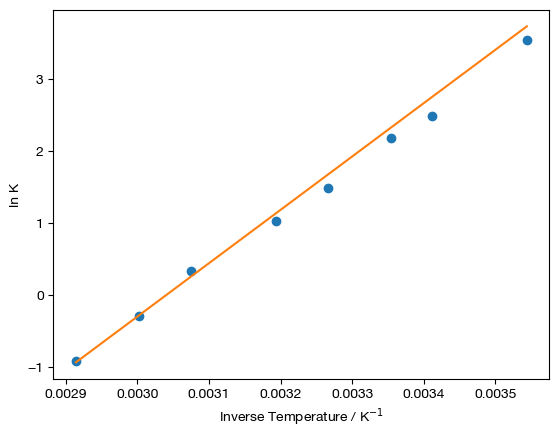

In [6]:
m = 7400
c = -22.5
y_fit = linear_model(inverse_temperature, m, c)

plt.plot(inverse_temperature, ln_eq, 'o')
plt.plot(inverse_temperature, y_fit, '-')
plt.xlabel('Inverse Temperature / K$^{-1}$')
plt.ylabel('ln K')
plt.show()

The fit shown above isn't terrible, but it's clear that there's room for improvement. We can define a measure of how good our model of the data is by calculating the _sum of squared differences_.

$$\chi^{2} = \sum_{i} |y_{i} - f(x_{i})|^{2}$$

Here each $y_{i}$ is one of our observed values of $\ln K$ and each $f(x_{i})$ is the corresponding value that we predict using our linear model. We can pythonise this equation and write a function to calculate $\chi^{2}$ for us.

In [7]:
def error_function(model_params, x, y):
    """
    Calculates the sum of squared differences between the observed y-values and fitted (predicted) y-values.
    
    Args:
        model_params (list): m and c
        x (np.ndarray): x-values
        y (np.ndarray): observed y-values
        
    Returns:
        float: sum of squared differences
    """
    m, c = model_params
    chi_squared = sum((y - linear_model(x, m, c)) ** 2)
    
    return chi_squared

We accept a list of model parameters (`model_params`) as opposed to $m$ and $c$ explicitly due to the fact that we will shortly be using the `minimize` function from the `scipy` library. `minimize` requires the first argument of the input function to be a list containing all of the free parameters that should be adjusted during the minimization procedure. We can use our initial guess for $m$ and $c$ from earlier as a starting point for calling `minimize`.

In [8]:
minimize(error_function, [7400, -22.5], (inverse_temperature, ln_eq))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.026025756680761968
        x: [ 6.924e+03 -2.107e+01]
      nit: 4
      jac: [ 3.027e-08 -4.424e-06]
 hess_inv: [[ 1.540e+06 -4.958e+03]
            [-4.958e+03  1.603e+01]]
     nfev: 45
     njev: 15

We can assign the results output above to a variable and access specifically the optimised parameters as follows:

In [9]:
opt_data = minimize(error_function, [7400, -22.5], (inverse_temperature, ln_eq))
opt_params = opt_data.x

opt_params

array([6924.03005359,  -21.06598328])

We can see that `minimize` has been able to lower the sum of squared differences by adjusting the values of $m$ and $c$. Replotting our model against the experimental data, it is clear that the fit is improved relative to what we started with.

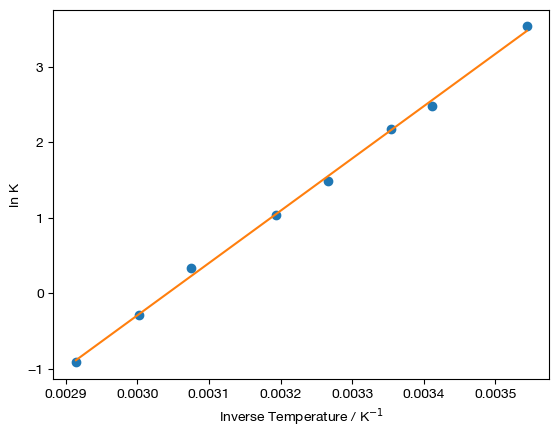

In [10]:
m, c = opt_params
y_fit = linear_model(inverse_temperature, m, c)

plt.plot(inverse_temperature, ln_eq, 'o')
plt.plot(inverse_temperature, y_fit, '-')
plt.xlabel('Inverse Temperature / K$^{-1}$')
plt.ylabel('ln K')
plt.show()

One way to perform linear regression in Python without writing your own model and error functions is to use `scipy.stats.linregress()`. This function takes the $x$ and $y$ data directly and returns the slope and intercept (along with some additional statistics).

In [11]:
from scipy.stats import linregress

result = linregress(inverse_temperature, ln_eq)
print(f"Slope (m): {result.slope}")
print(f"Intercept (c): {result.intercept}")

Slope (m): 6923.875242734126
Intercept (c): -21.065484494329496


Reassuringly, these values are essentially identical to those we obtained using `minimize()`. The small differences are due to numerical precision in the optimisation algorithm.

## Question 1.5 - Bonus Round

Having fit the Van't Hoff equation to our experimental data - we can easily extract $\Delta H$ and $\Delta S$.

$$\ln K = -\frac{\Delta H}{RT} + \frac{\Delta S}{R}$$

The enthalpy change is contained within the gradient.

$$m = -\frac{\Delta H}{R}$$
$$\Delta H = -Rm$$

Whilst the entropy change is related to the intercept.

$$c = \frac{\Delta S}{R}$$
$$\Delta S = Rc$$

Let's calculate these quantities from our optimized values of $m$ and $c$.

In [12]:
from scipy.constants import R

m, c = opt_params

delta_H = -R * m
delta_S = R * c

print(f'Delta H = {delta_H} J / mol or equally {delta_H / 1000} kJ / mol')
print(f'Delta S = {delta_S} J / molK')

Delta H = -57569.58904756049 J / mol or equally -57.56958904756049 kJ / mol
Delta S = -175.15233048994133 J / molK


## Question 2 - A First-Order Rate Equation

The procedure we followed above is not limited to linear systems, we can just as easily fit a non-linear model by minimizing the sum of squared differences between that model and the experimental data. In this question, we are concerned with fitting a first-order rate equation to a series of time and concentration data.

$$[\mathrm{H}_{2}\mathrm{O}_{2}](t) = [\mathrm{H}_{2}\mathrm{O}_{2}]_{0}\exp(-kt)$$

We are provided with the relevant data for the decomposition of hydrogen peroxide in the presence of excess Ce$^{\text{III}}$.

|Time / s|\[H$_{2}$O$_{2}$\] / moldm$^{-3}$|
|--------|---------------------------------|
|2       |6.23                             |
|4       |4.84                             |
|6       |3.76                             |
|8       |3.20                             |
|10      |2.60                             |
|12      |2.16                             |
|14      |1.85                             |
|16      |1.49                             |
|18      |1.27                             |
|20      |1.01                             |

As with Exercise 1, we would normally read the data from the file `exercise_2.dat`:
```python
data = np.loadtxt('data/exercise_2.dat', skiprows=1)
time = data[:, 0]
concs = data[:, 1]
```

For this worked example, we will enter the data directly:

In [13]:
time = np.array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
concs = np.array([6.23, 4.84, 3.76, 3.20, 2.60, 2.16, 1.85, 1.49, 1.27, 1.01])

We can now plot time against \[H$_{2}$O$_{2}$\].

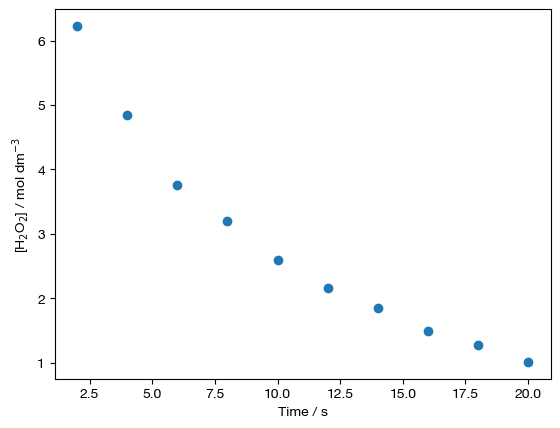

In [14]:
plt.plot(time, concs, 'o')
plt.xlabel('Time / s')
plt.ylabel('[H$_{2}$O$_{2}$] / mol dm$^{-3}$')
plt.show()

Sure enough, it doesn't look linear this time - but we press on. Time to pythonise the first-order rate equation.

In [15]:
def first_order(time, init_conc, k):
    """
    Model a first-order rate equation to predict [H2O2] from t.
    
    Args:
        time (np.ndarray): time values
        init_conc (float): [H2O2]0 i.e. the initial concentration of hydrogen peroxide
        k (float): rate constant
        
    Returns:
        np.ndarray: [H2O2] for each input t
    """
    
    concs = init_conc * np.exp(-k * time)
    
    return concs

We can also define an `error_function` to calculate the sum of squared differences, this time around we call our `first_order` function in place of the `linear_model`, but the concept is very much the same.

In [16]:
def error_function(model_params, time, concs):
    """
    Calculate a sum of squared differences between the observed concentration of H2O2 
    at time t and the corresponding values predicted via a first-order rate equation.
    
    Args:
        model_params (list): initial concentration of H2O2 and the rate constant
        time (np.ndarray): time data
        concs (np.ndarray): observed concentration data
        
    Returns:
        float: sum of squared differences
    """
    
    init_conc, k = model_params
    chi_squared = sum((concs - first_order(time, init_conc, k)) ** 2)
    
    return chi_squared

Once again, we minimize our error function with respect to the free parameters of our model - in this case `init_conc` (\[H$_{2}$O$_{2}$\]$_{0}$) and `k` (the rate constant).

In [17]:
minimize(error_function, [7, 0.1], (time, concs))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.13373044840256892
        x: [ 7.422e+00  1.031e-01]
      nit: 6
      jac: [ 9.313e-09  3.632e-07]
 hess_inv: [[ 7.694e-01  1.231e-02]
            [ 1.231e-02  2.978e-04]]
     nfev: 33
     njev: 11

It looks like our minimization worked just fine. Now we can use the optimized parameters to plot our model alongside the experimental data.

In [21]:
opt_data = minimize(error_function, [7, 0.1], (time, concs))
opt_params = opt_data.x

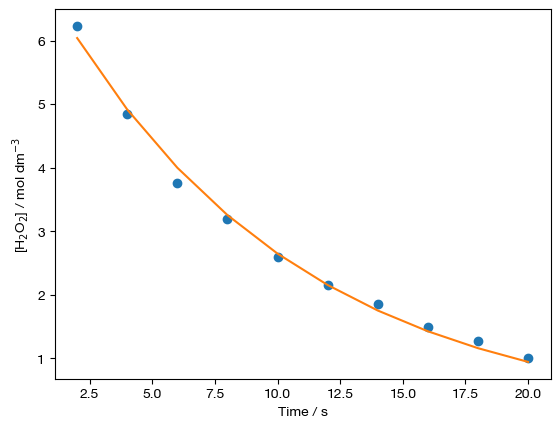

[H2O2]0 = 7.42164402082281 mol / dm^3
k = 0.10308255365613304 s^-1


In [22]:
init_conc, k = opt_params
fitted_concs = first_order(time, init_conc, k)

plt.plot(time, concs, 'o')
plt.plot(time, fitted_concs, '-')
plt.xlabel('Time / s')
plt.ylabel('[H$_{2}$O$_{2}$] / mol dm$^{-3}$')
plt.show()

print(f'[H2O2]0 = {init_conc} mol / dm^3')
print(f'k = {k} s^-1')

We can also perform non-linear least-squares fitting without writing an explicit error function by using `scipy.optimize.curve_fit()`. Here, we pass our starting guesses via the optional `p0` parameter to help the optimiser converge efficiently.

In [25]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(first_order, time, concs, p0=[7, 0.1])
print(f"[A]_0 = {popt[0]}")
print(f"k = {popt[1]}")

[A]_0 = 7.421644124098848
k = 0.10308255602605224


The first array returned by `curve_fit` contains the optimised parameters&mdash;reassuringly, these match the values we obtained using `minimize()`. The second array is the covariance matrix, which provides information about the uncertainties in the fitted parameters.